<img src="https://s3-sa-east-1.amazonaws.com/preditiva.ai/diversos/preditiva_assinatura.jpg">

# Detecção de Anomalias com Isolation Forest e AutoEncoder

Referências:
- Dataset Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud

## Hands On: Fraude em Cartão de Crédito

### Importação das bibliotecas

In [2]:
# Módulos de manipulação de dados
import numpy as np
import pandas as pd

# Módulos gráficos
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(8,8)})

# Módulos de modelagem
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Para utilizar esta biblioteca: pip install pyod
import pyod
from pyod.models.auto_encoder import AutoEncoder

In [3]:
def cria_grafico_var_qualitativa(tab, tamanho=(8,4), decimais=4):

    # Aumenta o tamanho do gráfico (largura 8 e altura 4)
    fig = plt.figure(figsize=tamanho)

    # Cria um gráfico de barras usando o indice da tabela como rótulos do eixo X
    cor = np.random.rand(3)
    plt.bar(tab.index,tab['Freq_Relativa'],width = 0.7, tick_label=tab.index,color=cor,alpha=0.6)

    plt.ylim(0,tab['Freq_Relativa'].max()+0.2)
    plt.title("Frequência Relativa de {}".format(list(tab.columns)[0]))

    # cria um conjunto de pares de rótulos e frequencias relativas
    for x,y in zip(tab.index,tab['Freq_Relativa']):

        # formata o rotulo do percentual
        formato = "{" + f":.{decimais}f" + "}"
        rotulo = formato.format(y)

        # coloca o rotulo na posição (x,y), alinhado ao centro e com distância 0,5 do ponto (x,y)
        plt.annotate(rotulo,(x,y),ha='center',textcoords="offset points",xytext=(0,5))
        
        
def tabela_bivariada(data, var, decimais=4):
    
    df = pd.DataFrame(data[var].value_counts()).sort_values(by=var,ascending=False)
    total = df[var].sum()
    df['Freq_Relativa'] = (df[var]/total).round(decimals=decimais)
    df['Freq_Acumulada'] = df['Freq_Relativa'].cumsum().round(decimals=decimais)
    return df

### Importação da base de dados

In [4]:
df = pd.read_csv('creditcard.csv').sample(frac=0.1)
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
119523,75481.0,-2.329451,1.539804,-0.109885,-3.273410,-0.479952,-0.603382,-0.265619,1.307861,0.207241,...,0.167631,0.061503,0.098053,-0.275291,-0.064809,-0.457881,-0.581552,-0.043409,3.71,0
126652,78046.0,-0.810493,0.402006,2.595966,-1.921289,-0.513657,-0.472802,0.375620,0.038173,1.470832,...,-0.021286,0.385537,-0.324864,0.395288,0.409455,-0.774100,0.203651,-0.086476,1.00,0
13078,22952.0,1.165284,-0.304464,1.150919,-0.487303,-1.114758,-0.490269,-0.721700,0.000004,3.075297,...,-0.107689,0.199480,0.037120,0.364368,0.358112,-0.716788,0.082179,0.030501,10.60,0
177799,123349.0,2.136828,-1.357611,-2.494476,-1.821136,-0.038807,-0.671519,-0.043809,-0.481216,-2.459763,...,0.089916,0.433140,-0.159165,0.253714,0.390838,0.042765,-0.079555,-0.059211,145.20,0
3302,2847.0,1.116329,0.105899,0.273680,1.211110,0.062516,0.339820,-0.017459,0.145297,0.041597,...,-0.061918,-0.006663,-0.128932,-0.284796,0.673811,-0.311715,0.033267,0.005268,23.26,0


### Pré-processamento dos dados

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28481 entries, 119523 to 70953
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    28481 non-null  float64
 1   V1      28481 non-null  float64
 2   V2      28481 non-null  float64
 3   V3      28481 non-null  float64
 4   V4      28481 non-null  float64
 5   V5      28481 non-null  float64
 6   V6      28481 non-null  float64
 7   V7      28481 non-null  float64
 8   V8      28481 non-null  float64
 9   V9      28481 non-null  float64
 10  V10     28481 non-null  float64
 11  V11     28481 non-null  float64
 12  V12     28481 non-null  float64
 13  V13     28481 non-null  float64
 14  V14     28481 non-null  float64
 15  V15     28481 non-null  float64
 16  V16     28481 non-null  float64
 17  V17     28481 non-null  float64
 18  V18     28481 non-null  float64
 19  V19     28481 non-null  float64
 20  V20     28481 non-null  float64
 21  V21     28481 non-null  float6

In [6]:
# Seleção das variáveis explicativas
x_var = df.columns[1:30]

# Padronização da escala das variáveis numéricas
stdscaler = StandardScaler()
stdscaler.fit(df[x_var])

df_ad = pd.DataFrame(data=stdscaler.transform(df[x_var]),
                     index=df.index,
                     columns=x_var)
df_ad.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.848100e+04,2.848100e+04,2.848100e+04,2.848100e+04,2.848100e+04,2.848100e+04,2.848100e+04,2.848100e+04,2.848100e+04,2.848100e+04,...,2.848100e+04,2.848100e+04,2.848100e+04,2.848100e+04,2.848100e+04,2.848100e+04,2.848100e+04,2.848100e+04,2.848100e+04,2.848100e+04
mean,-1.696461e-17,7.484387e-19,-2.968807e-17,-1.496877e-17,1.197502e-17,-5.239071e-18,-2.095628e-17,-2.744275e-18,-6.985428e-18,7.484387e-18,...,-2.744275e-18,-7.733866e-18,9.979182e-19,4.989591e-19,-4.490632e-18,1.347190e-17,-6.236989e-18,2.245316e-18,-2.494796e-18,1.097710e-17
std,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,...,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00
min,-1.721497e+01,-3.191789e+01,-1.840921e+01,-3.582012e+00,-1.600103e+01,-1.223476e+01,-2.388547e+01,-3.368464e+01,-8.680932e+00,-1.966001e+01,...,-2.666265e+01,-2.577602e+01,-1.218993e+01,-6.618648e+01,-4.550380e+00,-1.970593e+01,-3.426985e+00,-2.564866e+01,-2.869115e+01,-3.658501e-01
25%,-4.921523e-01,-3.818738e-01,-5.981949e-01,-5.989337e-01,-5.391541e-01,-5.887091e-01,-4.657173e-01,-1.603074e-01,-5.924974e-01,-4.979006e-01,...,-2.926216e-01,-2.955967e-01,-7.416756e-01,-2.353409e-01,-5.837274e-01,-6.023339e-01,-6.757244e-01,-1.910600e-01,-1.826861e-01,-3.417045e-01
50%,3.645895e-03,3.352370e-02,1.182757e-01,-8.458832e-03,-4.821826e-02,-2.175382e-01,4.522325e-02,2.578290e-02,-4.583057e-02,-8.615810e-02,...,-8.984533e-02,-4.071544e-02,8.950097e-03,-1.375292e-02,6.547232e-02,3.612616e-02,-1.080870e-01,-2.966108e-03,4.196909e-02,-2.724931e-01
75%,6.865117e-01,4.913394e-01,6.877343e-01,5.291688e-01,4.635037e-01,3.023988e-01,4.920023e-01,2.752151e-01,5.471386e-01,4.263875e-01,...,1.831742e-01,2.301165e-01,7.298974e-01,2.161683e-01,7.114782e-01,6.703997e-01,4.954344e-01,2.325025e-01,2.723327e-01,-4.372601e-02
max,1.274638e+00,9.827667e+00,2.644618e+00,8.407016e+00,1.868702e+01,1.137414e+01,1.953276e+01,1.386195e+01,7.722169e+00,1.170966e+01,...,3.324848e+01,3.459446e+01,8.353300e+00,3.328268e+01,6.608793e+00,1.047632e+01,6.683524e+00,2.117377e+01,5.481059e+01,5.012369e+01


### Separação das bases em Treino e Teste

In [7]:
# Separação da base em treino e teste
x_train, x_test = train_test_split(df_ad, 
                                   test_size=0.30,
                                   random_state=42)

## Isolation Forest

In [8]:
# Treinamento de um modelo Isolation Forest
modelo_if = IsolationForest(random_state=42, 
                            contamination='auto',
                            n_jobs=6)
modelo_if.fit(x_train)

IsolationForest(n_jobs=6, random_state=42)

In [9]:
# Escoragem dos DataFrames de Treino e Teste
isoforest_train_anomaly_score = modelo_if.decision_function(x_train)
isoforest_train_outlier_pred = modelo_if.predict(x_train)

isoforest_test_anomaly_score = modelo_if.decision_function(x_test)
isoforest_test_outlier_pred = modelo_if.predict(x_test)

### Análise do conjunto de treino

In [10]:
# Construção do DataFrame de resultados
isoforest_train_outlier = pd.concat([pd.DataFrame(isoforest_train_outlier_pred, 
                                                  columns=['outlier_pred'], 
                                                  index=x_train.index),
                                     pd.DataFrame(isoforest_train_anomaly_score, 
                                                  columns=['anomaly_score'], 
                                                  index=x_train.index)],
                                    axis=1)

isoforest_train_outlier

,outlier_pred,anomaly_score
263928,1,0.104531
187054,1,0.082385
146435,1,0.117608
258059,1,0.106172
131106,1,0.134427
...,...,...
169424,1,0.087437
145095,1,0.103793
55730,1,0.142111
215895,1,0.098536


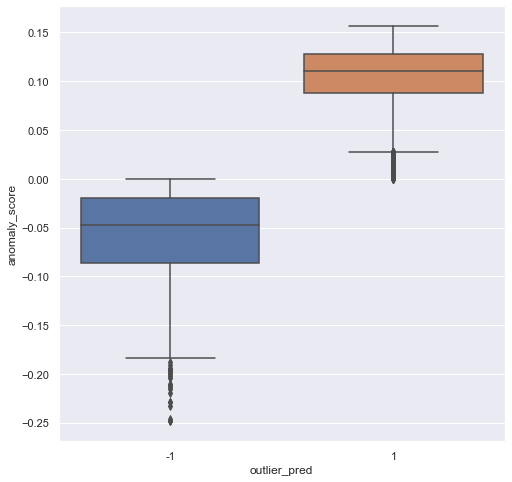

In [13]:
# Distribuição dos scores por classe de predição: Boxplot
sns.boxplot(x='outlier_pred',
            y='anomaly_score',
            data=isoforest_train_outlier);

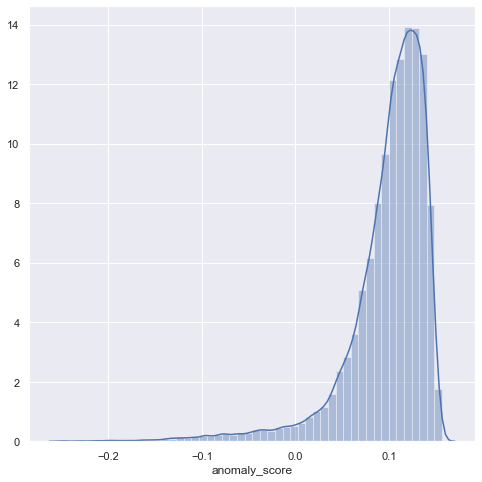

In [14]:
# Distribuição dos scores por classe de predição: Histograma
sns.distplot(isoforest_train_outlier['anomaly_score']);

### Análise do conjunto de teste

In [15]:
# Construção do DataFrame de resultados
isoforest_test_outlier = pd.concat([pd.DataFrame(isoforest_test_outlier_pred, 
                                                 columns=['outlier_pred'], 
                                                 index=x_test.index),
                                    pd.DataFrame(isoforest_test_anomaly_score, 
                                                 columns=['anomaly_score'], 
                                                 index=x_test.index)],
                                   axis=1)

isoforest_test_outlier

,outlier_pred,anomaly_score
165743,1,0.141024
162331,1,0.016230
99696,1,0.090284
198836,1,0.081570
280279,1,0.060133
...,...,...
183426,1,0.107091
46309,1,0.102717
140170,1,0.061090
251647,1,0.105991


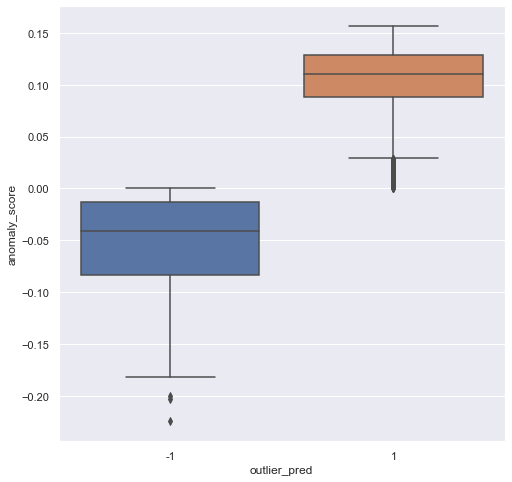

In [16]:
# Distribuição dos scores por classe de predição: Boxplot
sns.boxplot(x='outlier_pred',
            y='anomaly_score',
            data=isoforest_test_outlier);

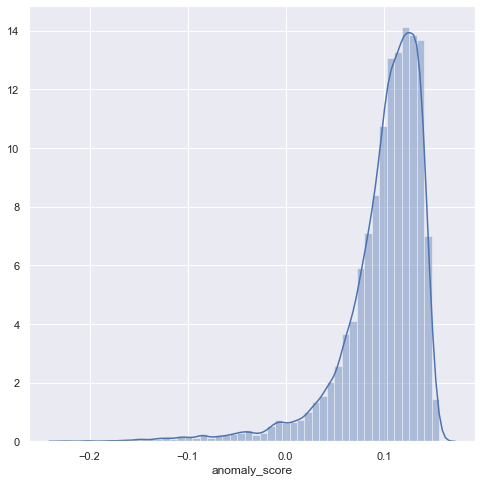

In [17]:
# Distribuição dos scores por classe de predição: Histograma
sns.distplot(isoforest_test_outlier['anomaly_score']);

### Qual proporção de fraudes foi identificada como anomalia?

In [54]:
# Incorporação da predição de outliers
df_scored_isoforest_train = df.join(isoforest_train_outlier)
df_scored_isoforest_test = df.join(isoforest_test_outlier)

In [55]:
df_scored_isoforest_train[['Class','outlier_pred','anomaly_score']].pivot_table(
    index='Class',
    columns='outlier_pred',
    aggfunc='count')

anomaly_score       
outlier_pred          -1.0    1.0
Class                            
0                      755  19144
1                       29      8

In [64]:
t = -0.1
df_scored_isoforest_train['manual_class'] = np.where(df_scored_isoforest_train['anomaly_score']>t,1,0)
df_scored_isoforest_train[['Class','manual_class','anomaly_score']].pivot_table(
    index='Class',
    columns='manual_class',
    aggfunc='count')

anomaly_score       
manual_class             0      1
Class                            
0                      128  19771
1                       18     19

In [65]:
df_scored_isoforest_test['manual_class'] = np.where(df_scored_isoforest_test['anomaly_score']>t,1,0)
df_scored_isoforest_test[['Class','manual_class','anomaly_score']].pivot_table(
    index='Class',
    columns='manual_class',
    aggfunc='count')

anomaly_score      
manual_class             0     1
Class                           
0                       49  8486
1                        3     7

## AutoEncoder

In [23]:
modelo_ae = AutoEncoder(hidden_neurons=[16,8,4,2,4,8,16], 
                        batch_size=128,
                        epochs=50)
modelo_ae.fit(x_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 29)                870       
_________________________________________________________________
dropout_9 (Dropout)          (None, 29)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 29)                870       
_________________________________________________________________
dropout_10 (Dropout)         (None, 29)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                480       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                

AutoEncoder(batch_size=128, contamination=0.1, dropout_rate=0.2, epochs=50,
      hidden_activation='relu', hidden_neurons=[16, 8, 4, 2, 4, 8, 16],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x00000262EE48A430>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [24]:
# Escoragem dos DataFrames de Treino e Teste
autoenc_train_anomaly_score = modelo_ae.decision_function(x_train)
autoenc_train_outlier_pred = modelo_ae.predict(x_train)

autoenc_test_anomaly_score = modelo_ae.decision_function(x_test)
autoenc_test_outlier_pred = modelo_ae.predict(x_test)

### Análise no conjunto de treino

In [25]:
# Construção do DataFrame de resultados
autoenc_train_outlier = pd.concat([pd.DataFrame(autoenc_train_outlier_pred, 
                                                columns=['outlier_pred'], 
                                                index=x_train.index),
                                   pd.DataFrame(autoenc_train_anomaly_score, 
                                                columns=['anomaly_score'], 
                                                index=x_train.index)],
                                  axis=1)
autoenc_train_outlier

,outlier_pred,anomaly_score
263928,0,4.394751
187054,0,5.378288
146435,0,3.977009
258059,0,4.273420
131106,0,3.327848
...,...,...
169424,0,4.824611
145095,0,4.147498
55730,0,3.060692
215895,0,4.791564


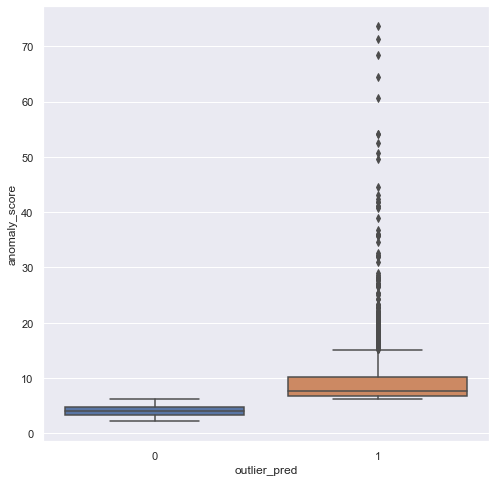

In [26]:
# Distribuição dos scores por classe de predição: Boxplot
sns.boxplot(x='outlier_pred',
            y='anomaly_score',
            data=autoenc_train_outlier);

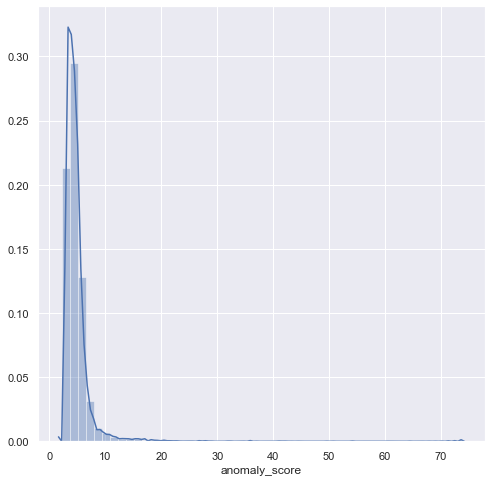

In [27]:
# Distribuição dos scores por classe de predição: Histograma
sns.distplot(autoenc_train_outlier['anomaly_score']);

### Análise no conjunto de teste

In [29]:
# Construção do DataFrame de resultados
autoenc_test_outlier = pd.concat([pd.DataFrame(autoenc_test_outlier_pred, 
                                                columns=['outlier_pred'], 
                                                index=x_test.index),
                                   pd.DataFrame(autoenc_test_anomaly_score, 
                                                columns=['anomaly_score'], 
                                                index=x_test.index)],
                                  axis=1)
autoenc_test_outlier

,outlier_pred,anomaly_score
165743,0,3.072934
162331,1,7.098232
99696,0,5.129872
198836,0,4.976048
280279,0,5.809138
...,...,...
183426,0,4.554173
46309,0,4.219049
140170,0,5.819235
251647,0,4.058010


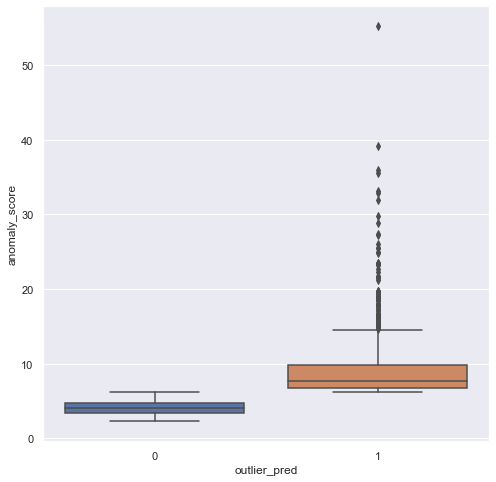

In [30]:
# Distribuição dos scores por classe de predição: Boxplot
sns.boxplot(x='outlier_pred',
            y='anomaly_score',
            data=autoenc_test_outlier);

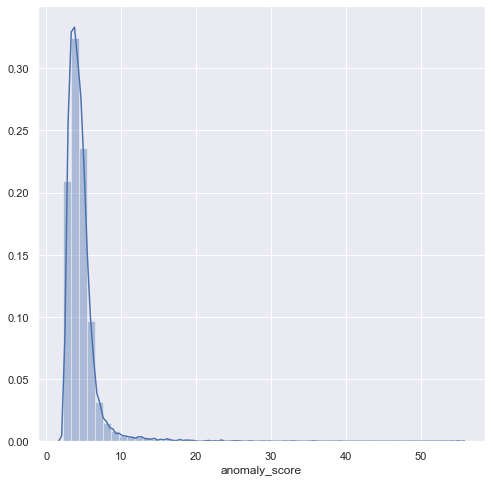

In [31]:
# Distribuição dos scores por classe de predição: Histograma
sns.distplot(autoenc_test_outlier['anomaly_score']);

### Qual proporção de fraudes foi identificada como anomalia?

In [43]:
# Incorporação da predição de outliers
df_scored_autoenc_train = df.join(autoenc_train_outlier)
df_scored_autoenc_test = df.join(autoenc_test_outlier)

In [44]:
df_scored_autoenc_train[['Class','outlier_pred','anomaly_score']].pivot_table(
    index='Class',
    columns='outlier_pred',
    aggfunc='count')

anomaly_score      
outlier_pred           0.0   1.0
Class                           
0                    17937  1962
1                        5    32

In [47]:
t = 10
df_scored_autoenc_train['manual_class'] = np.where(df_scored_autoenc_train['anomaly_score']>t,1,0)
df_scored_autoenc_train[['Class','manual_class','anomaly_score']].pivot_table(
    index='Class',
    columns='manual_class',
    aggfunc='count')

anomaly_score     
manual_class             0    1
Class                          
0                    19416  483
1                        8   29

In [48]:
df_scored_autoenc_test['manual_class'] = np.where(df_scored_autoenc_test['anomaly_score']>t,1,0)
df_scored_autoenc_test[['Class','manual_class','anomaly_score']].pivot_table(
    index='Class',
    columns='manual_class',
    aggfunc='count')

anomaly_score     
manual_class             0    1
Class                          
0                     8350  185
1                        2    8

## DBSCAN

In [49]:
from sklearn.cluster import DBSCAN

In [51]:
# Ajuste do modelo DBSCAN
dbscan = DBSCAN(eps=7.0,
                min_samples=5, 
                n_jobs=-1).fit(x_train)

# Identificação das observações Core
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Contagem do número de cluster, desconsiderando as observações ruído
n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
n_noise_ = list(dbscan.labels_).count(-1)

print('Número de clusters estimado: %d' % n_clusters_)
print('Número de observações ruído: %d' % n_noise_)

Número de clusters estimado: 3
Número de observações ruído: 181


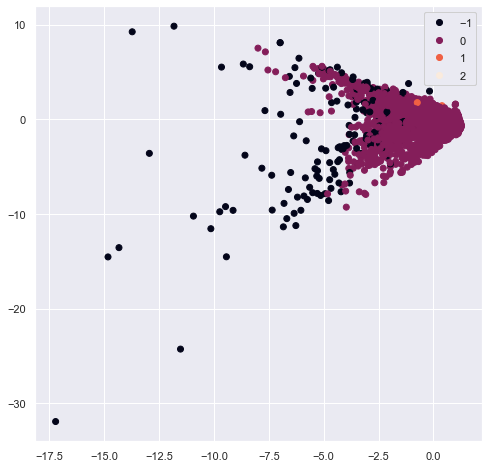

In [70]:
def plota_dispersao(X, v1, v2):
    fig, ax = plt.subplots()

    scatter1 = plt.scatter(X.iloc[:,v1],
                           X.iloc[:,v2],
                           c=dbscan.labels_)

    leg1 = ax.legend(*scatter1.legend_elements(num='auto'))
    ax.add_artist(leg1)

    scatter2 = plt.scatter(X.iloc[core_samples_mask,v1], 
                           X.iloc[core_samples_mask,v2], 
                           c='red',
                           marker='x',
                           alpha=0)
    plt.show()
    
plota_dispersao(x_train, 0,1)

In [73]:
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [71]:
df_dbscan = x_train.join(df[['Class']],how='left')
df_dbscan['dbscan_anomaly'] = dbscan.labels_ * -1
df_dbscan = df_dbscan[['Class','dbscan_anomaly','Amount']]

In [72]:
df_dbscan.pivot_table(index='Class', 
                      columns='dbscan_anomaly', 
                      aggfunc='count')

Amount               
dbscan_anomaly     -2 -1      0    1
Class                               
0                   1  1  19736  161
1                   3  5      9   20